In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers
from jax import random, jit

In [2]:
import jax
import jax.numpy as jnp
# Check available devices
print("Available devices:", jax.devices())

# Simple GPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]


2024-04-19 10:51:15.319471: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Computation result: [1. 4. 9.]


In [3]:
import torch
if torch.cuda.is_available():
    print("GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available.
GPU Name: NVIDIA A100-PCIE-40GB


In [4]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [5]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]
TARGETID = d['TARGETID'][SEL][~indice]
d = Planck18.distmod(z).value

In [6]:
apr_mag_g = apr_mag_g.astype(np.float32)
apr_mag_g_err = apr_mag_g_err.astype(np.float32)
k_gg = k_gg.astype(np.float32)

apr_mag_r = apr_mag_r.astype(np.float32)
apr_mag_r_err = apr_mag_r_err.astype(np.float32)
k_rr = k_rr.astype(np.float32)

d = d.astype(np.float32)
z = z.astype(np.float32)

In [8]:
# Initialize RNG
rng_key = random.PRNGKey(0)

# Sampler configuration
num_warmup, num_samples = 1000, 2000
i_start = 0
i_end = i_start+1000
# Initialize batch parameters for the entire dataset
init_params = {
    'sigma_I1': 0.5 * jnp.ones((1,)),  
    'M_X1': -25.0 * jnp.ones((1,)),  
    'a1': 0.8 * jnp.ones((1,)), 
    'sigma_I2': 0.5 * jnp.ones((1,)), 
    'M_X2': -25.0 * jnp.ones((1,)), 
    'a2': 1.8 * jnp.ones((1,)),  
    'A_x': jnp.ones(i_end-i_start-1) / (i_end-i_start-1),
    'B':0.5 * jnp.ones((1,)),  
    #'A_x': jnp.ones(apr_mag_g.shape[0]-1) / (apr_mag_g.shape[0]-1)  # Assuming A_x needs to be initialized uniformly
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True)

# Run the sampler over the entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, apr_mag_g[i_start:i_end], apr_mag_g_err[i_start:i_end], k_gg[i_start:i_end], apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], k_rr[i_start:i_end], d[i_start:i_end],z[i_start:i_end], 22.5, init_params=init_params)

# Get samples
samples = mcmc.get_samples()

# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 3000/3000 [01:51<00:00, 26.82it/s, 31 steps of size 1.66e-01. acc. prob=0.86] 


{'A_x': Array([[0.00102904, 0.00211702, 0.00068712, ..., 0.00241449, 0.00070187,
        0.00097502],
       [0.00095107, 0.00222657, 0.00067804, ..., 0.00230839, 0.00090822,
        0.00112888],
       [0.00110887, 0.00221665, 0.00046757, ..., 0.00243768, 0.0007531 ,
        0.00107575],
       ...,
       [0.00100155, 0.0021615 , 0.00076361, ..., 0.00238623, 0.00064705,
        0.001113  ],
       [0.00104401, 0.00218441, 0.0007193 , ..., 0.0024807 , 0.00080476,
        0.00100536],
       [0.0009581 , 0.00215326, 0.0007324 , ..., 0.00230844, 0.00071658,
        0.00112345]], dtype=float32), 'B': Array([[-0.4563434 ],
       [ 0.5277343 ],
       [-1.7003458 ],
       ...,
       [ 0.91396284],
       [ 0.94689846],
       [-0.38544118]], dtype=float32), 'M_X1': Array([[-23.601501],
       [-23.608799],
       [-23.610836],
       ...,
       [-23.598602],
       [-23.595718],
       [-23.61942 ]], dtype=float32), 'M_X2': Array([[-23.72503 ],
       [-23.719643],
       [-23.722546],

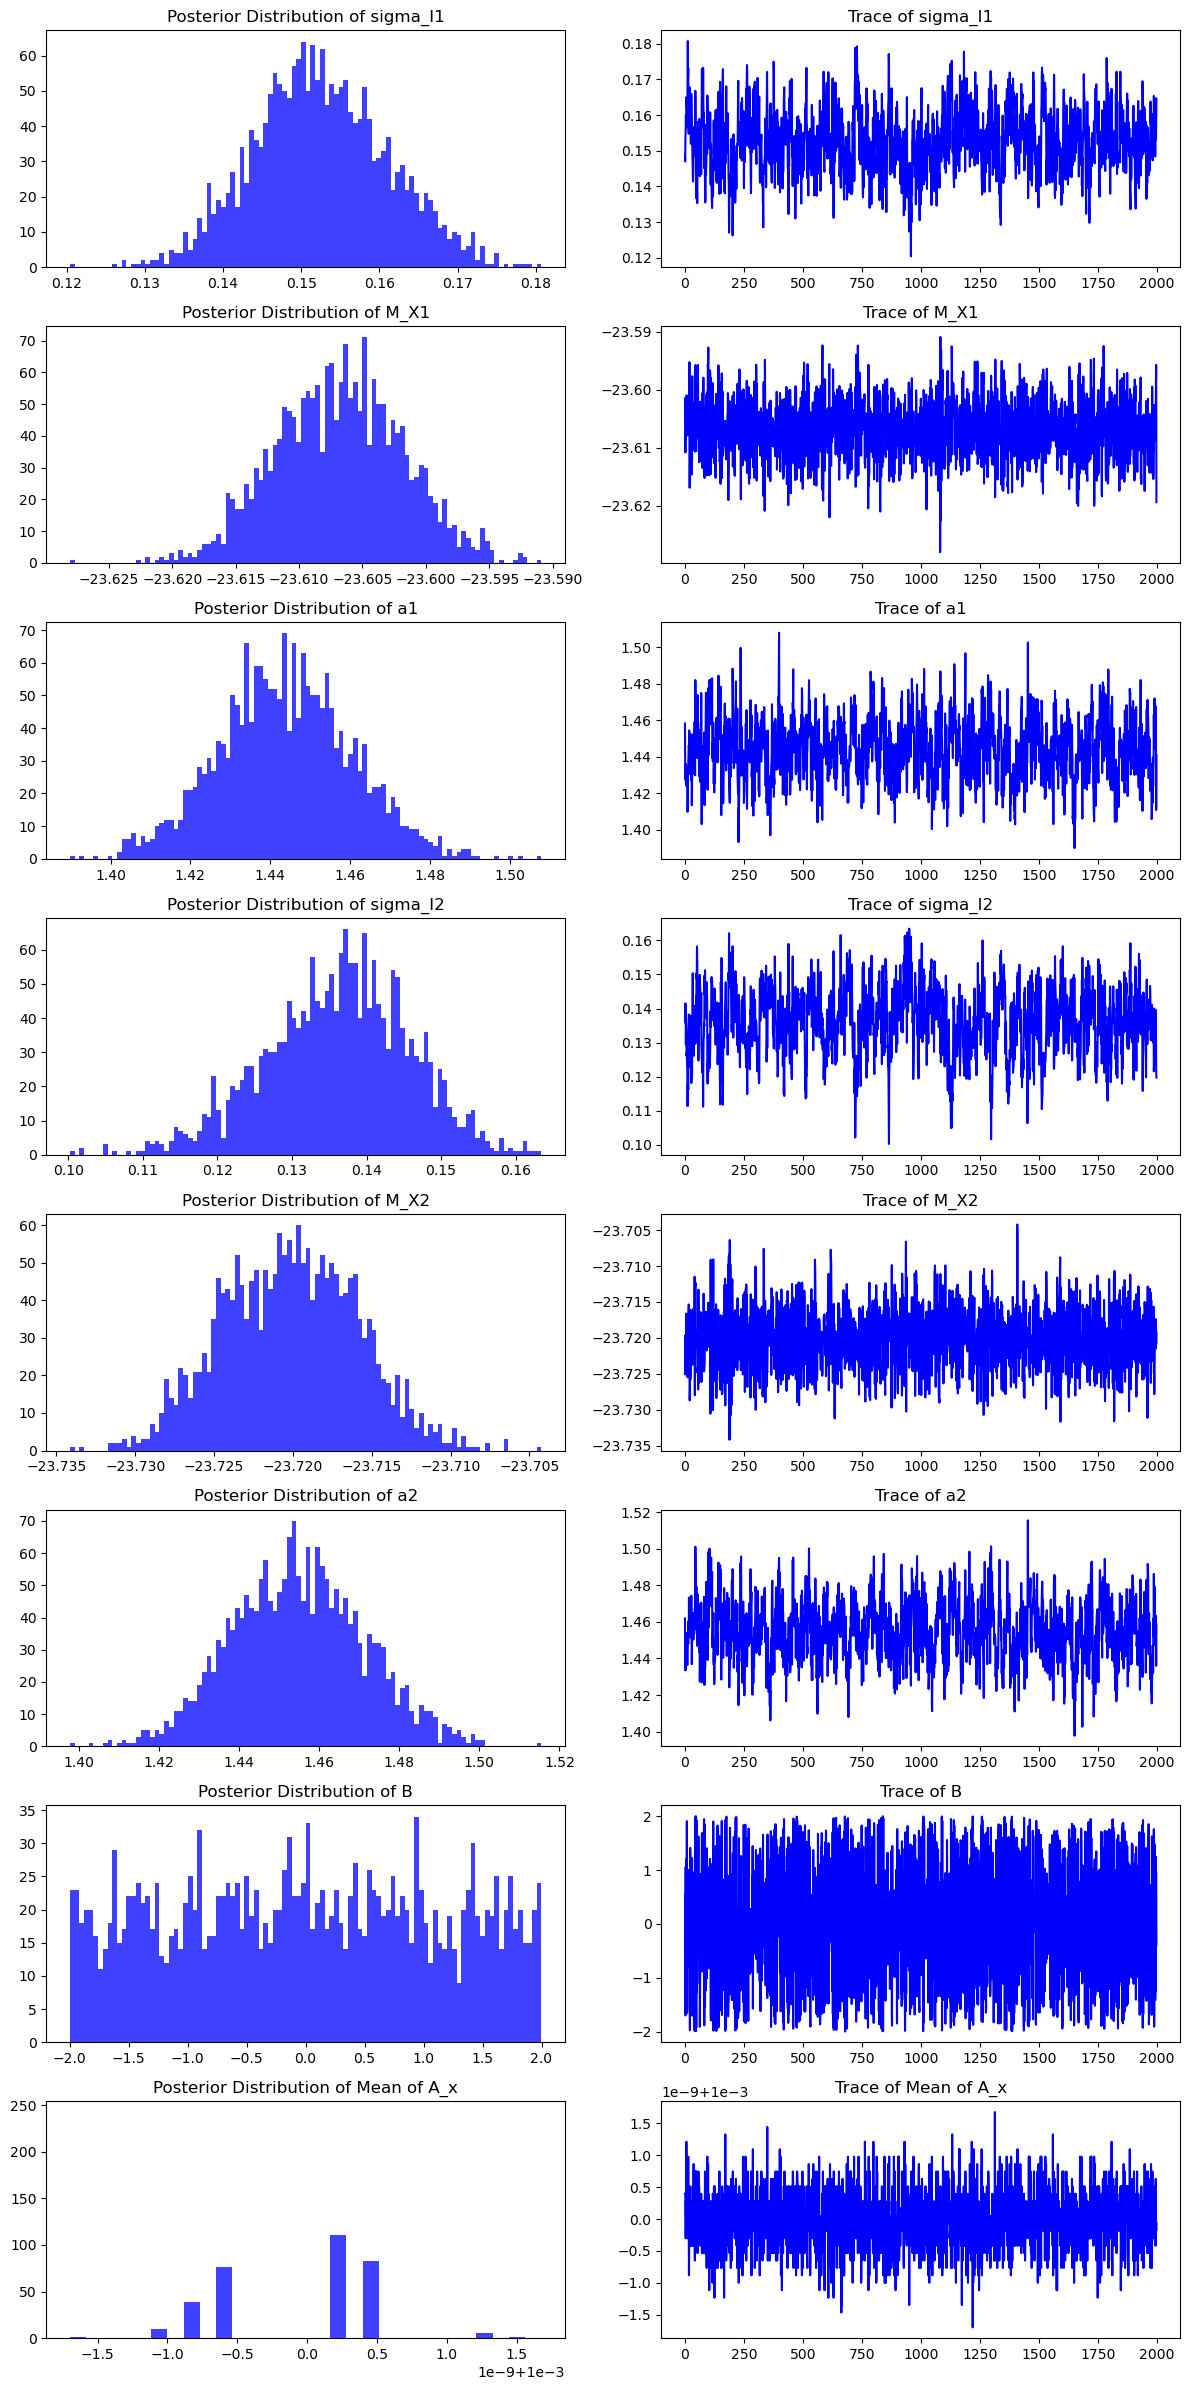

In [9]:
# Extract the chains and parameters
sigma_I1_samples = samples['sigma_I1'][:,0]
M_X1_samples = samples['M_X1'][:,0]
a1_samples = samples['a1'][:,0]
sigma_I2_samples = samples['sigma_I2'][:,0]
M_X2_samples = samples['M_X2'][:,0]
a2_samples = samples['a2'][:,0]
B_samples = samples['B'][:,0]
A_x_samples = samples['A_x']

# Creating a figure to hold the subplots
fig, axs = plt.subplots(8, 2, figsize=(12, 24))  # 7 parameters, each with a histogram and trace plot

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], sigma_I1_samples, 'sigma_I1')
plot_param(axs[1], M_X1_samples, 'M_X1')
plot_param(axs[2], a1_samples, 'a1')
plot_param(axs[3], sigma_I2_samples, 'sigma_I2')
plot_param(axs[4], M_X2_samples, 'M_X2')
plot_param(axs[5], a2_samples, 'a2')
plot_param(axs[6], B_samples, 'B')
plot_param(axs[7], A_x_samples.mean(axis=1), 'Mean of A_x')  # Mean across data points for A_x

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

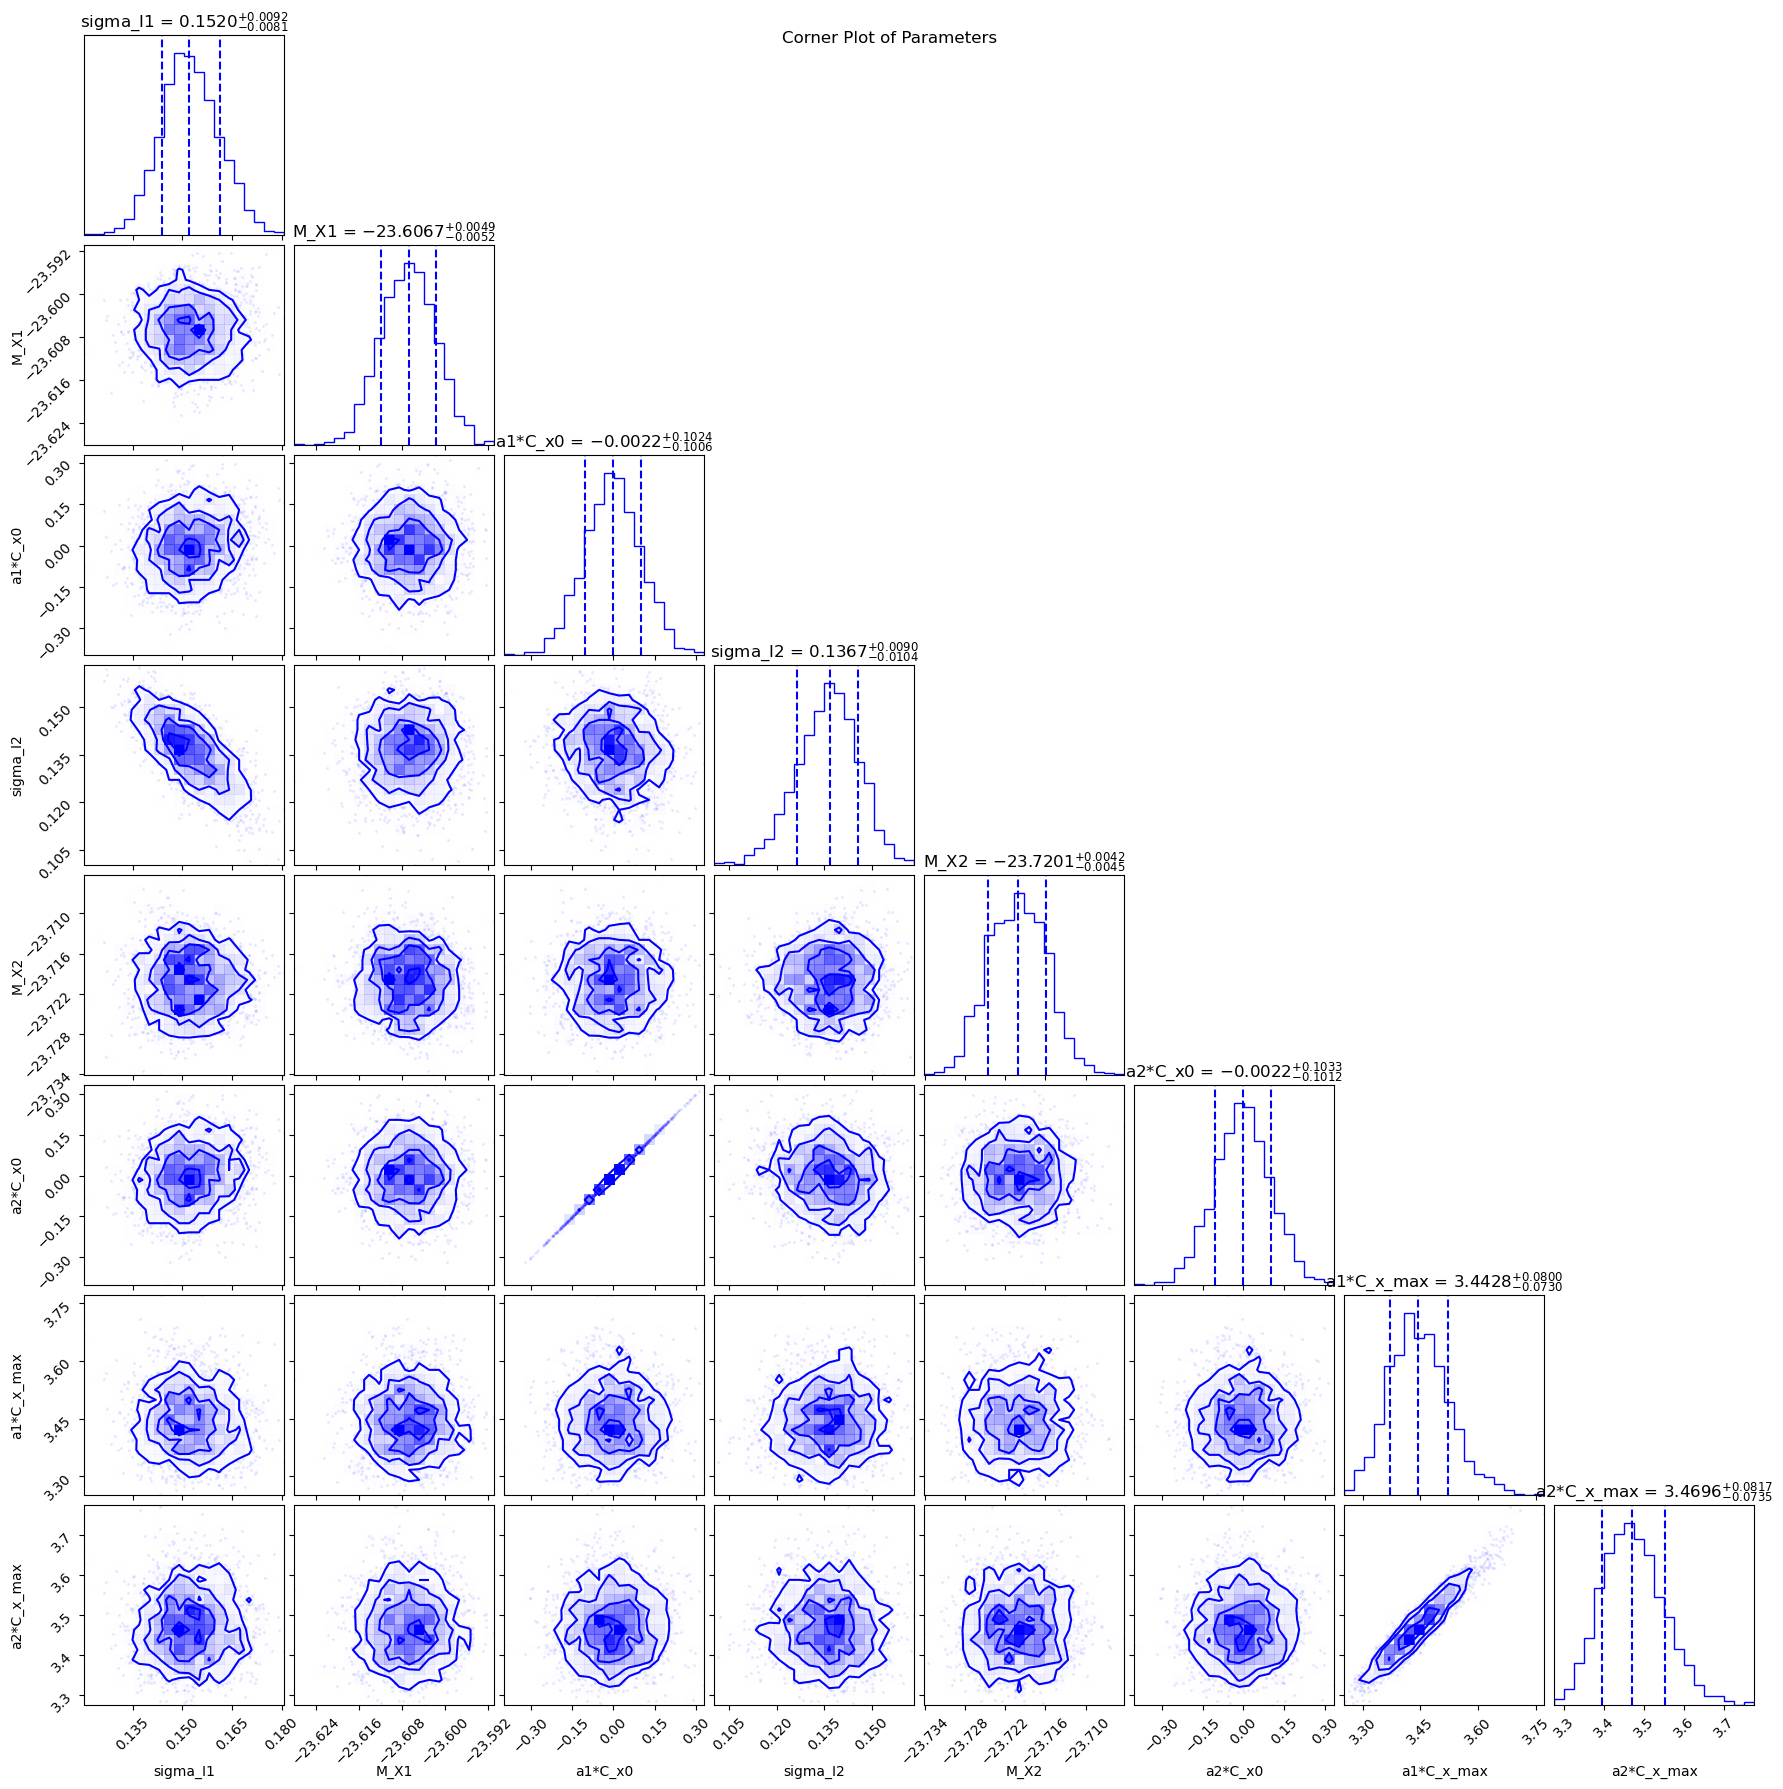

In [10]:
import corner
import numpy as np
A_x0_samples = A_x_samples[:,0]
A_x1_samples = A_x_samples[:,1]
C_x0_samples = (A_x0_samples - 1/(i_end-i_start))*(i_end-i_start)
C_x1_samples = (A_x1_samples - 1/(i_end-i_start))*(i_end-i_start)
A_x_samples_max = np.max(A_x_samples,axis=1)
C_x_samples_max = (A_x_samples_max - 1/(i_end-i_start))*(i_end-i_start)

# Extract samples for plotting
samples = np.vstack((sigma_I1_samples, M_X1_samples, a1_samples*C_x0_samples, sigma_I2_samples, M_X2_samples, a2_samples*C_x0_samples,a1_samples*C_x_samples_max,a2_samples*C_x_samples_max)).T

# Create a corner plot
fig = corner.corner(samples, labels=['sigma_I1', 'M_X1', 'a1*C_x0', 'sigma_I2', 'M_X2', 'a2*C_x0','a1*C_x_max','a2*C_x_max'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()

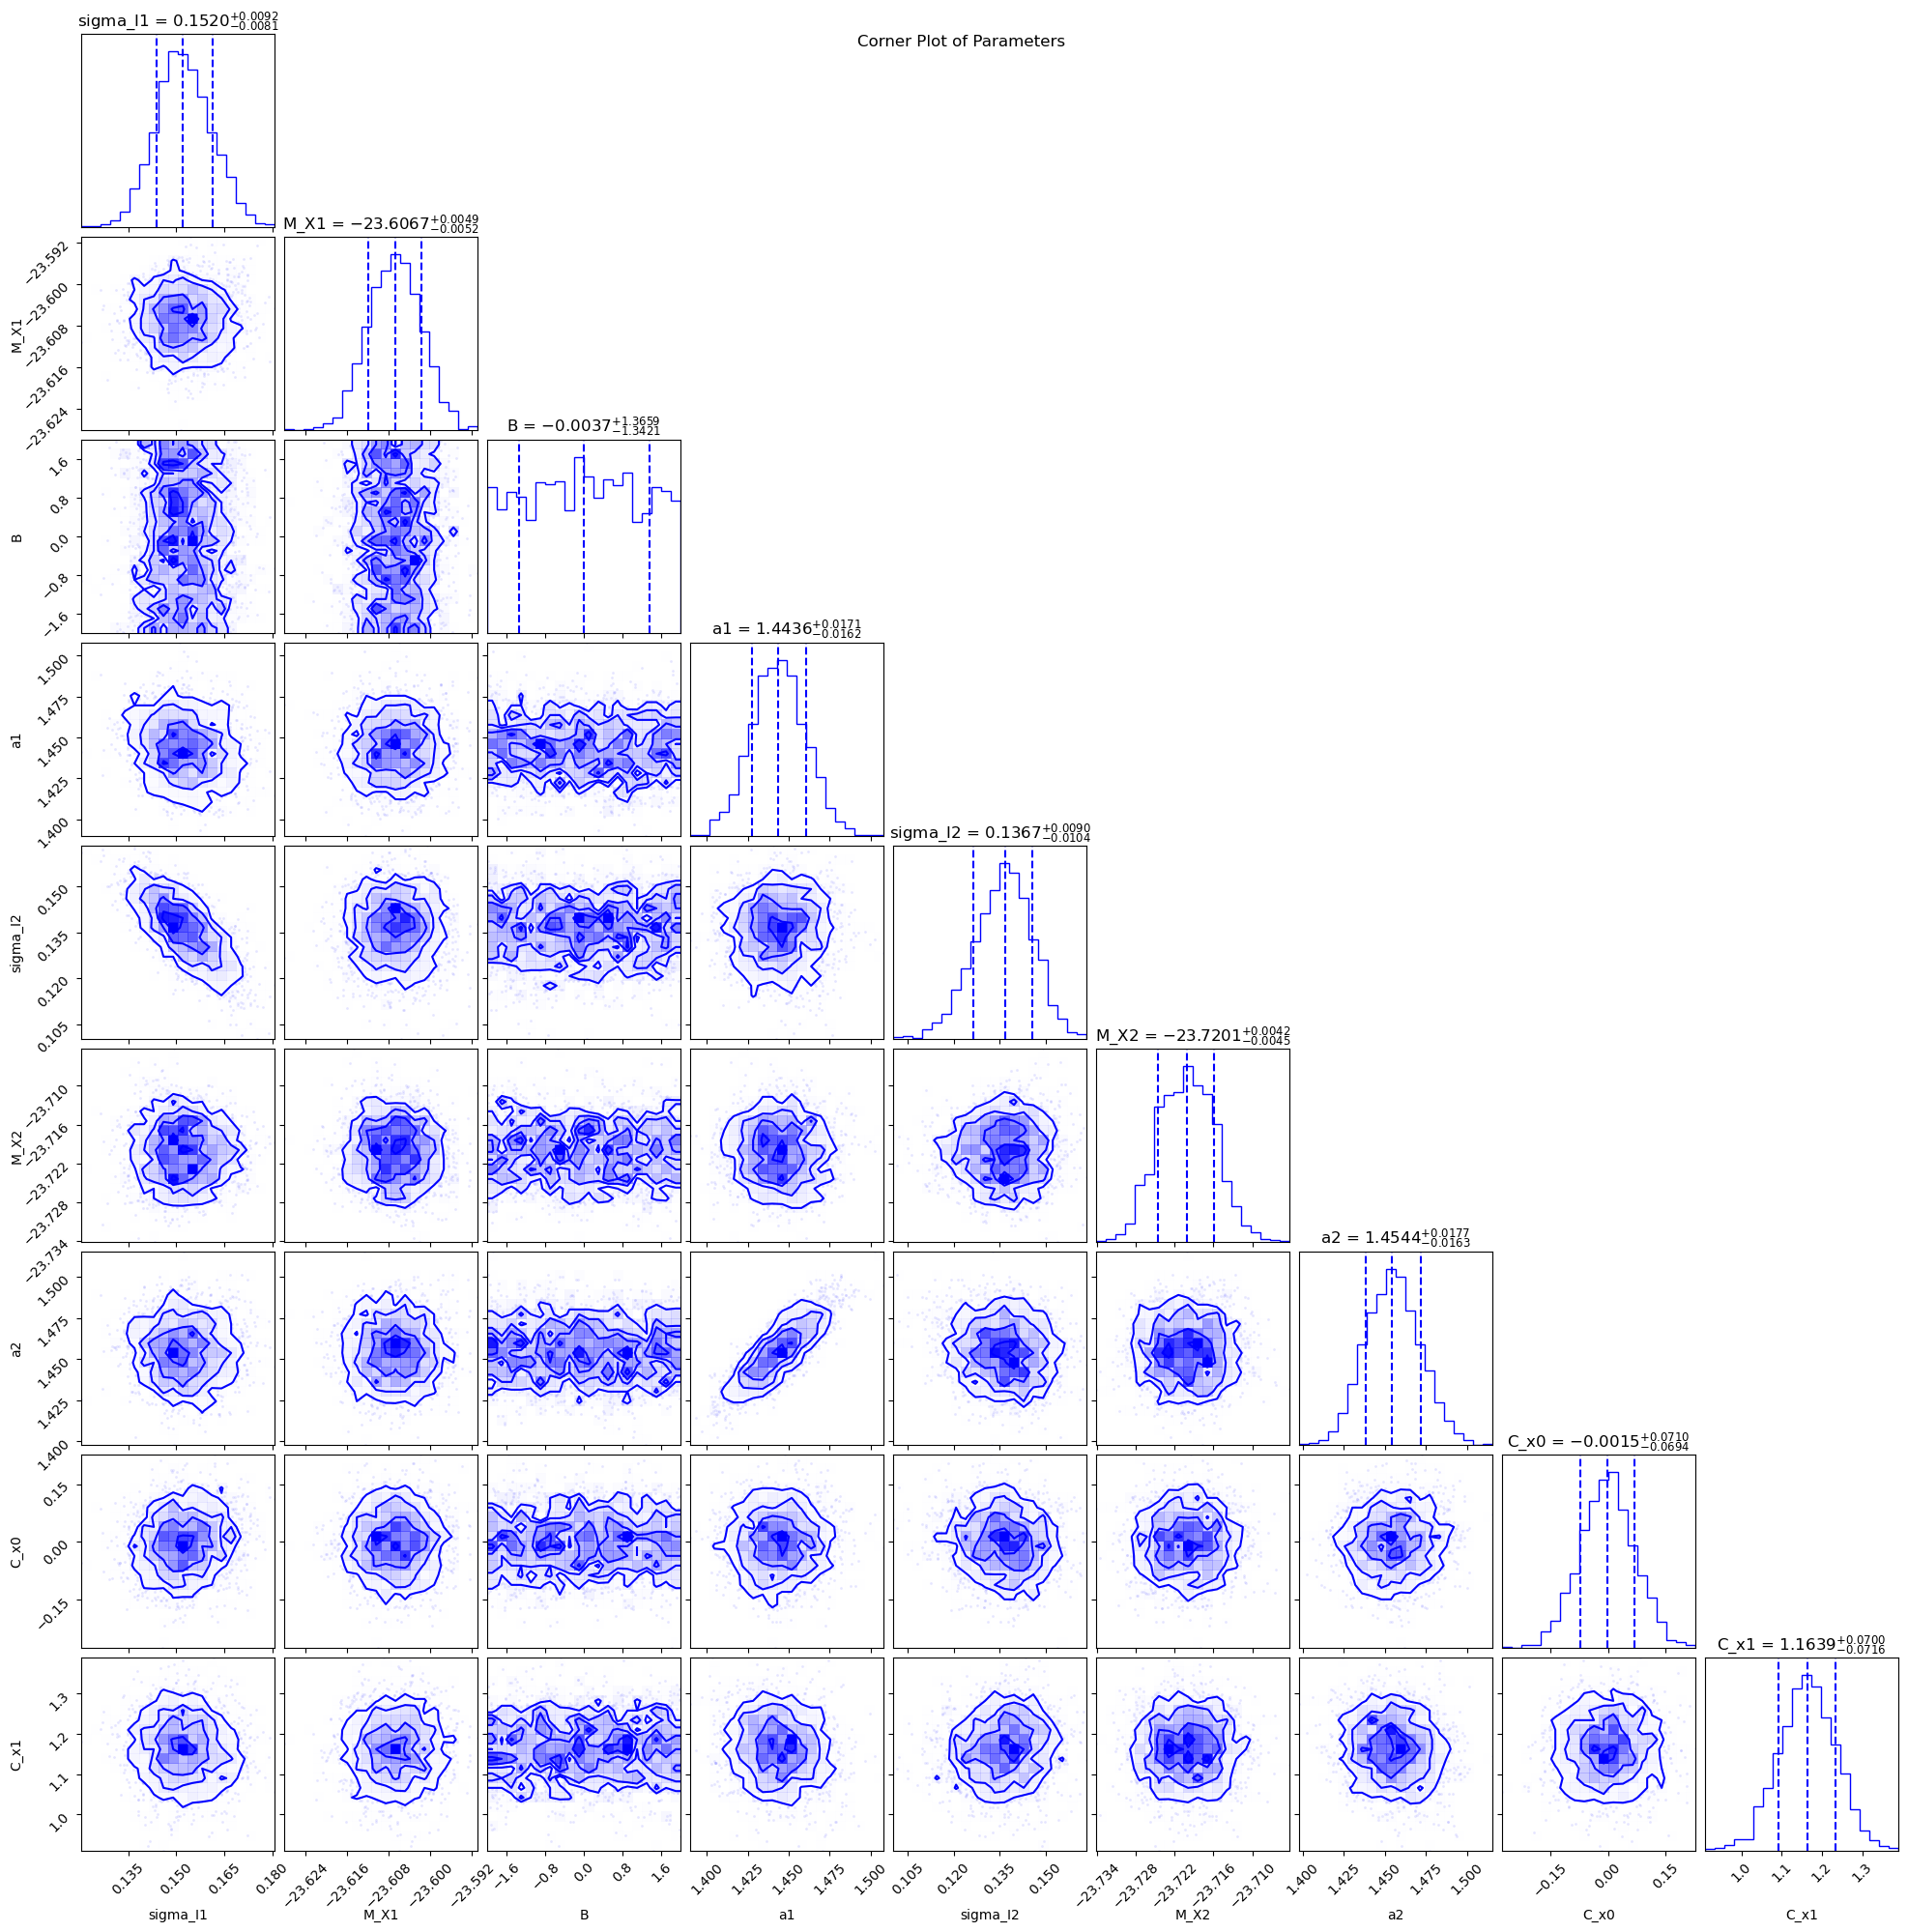

In [11]:
import corner
import numpy as np
# Extract samples for plotting
samples = np.vstack((sigma_I1_samples, M_X1_samples,B_samples, a1_samples, sigma_I2_samples, M_X2_samples, a2_samples,C_x0_samples,C_x1_samples)).T

# Create a corner plot
fig = corner.corner(samples, labels=['sigma_I1', 'M_X1','B' ,'a1', 'sigma_I2', 'M_X2', 'a2','C_x0','C_x1'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()

In [12]:
print(A_x_samples.shape)

(2000, 1000)


(array([23., 28., 23., 17., 28., 22., 13., 17., 17., 19., 23., 18., 13.,
        20., 17., 18., 13., 15., 25., 15., 19., 22., 15., 14., 18., 17.,
        18., 20., 17., 26., 19., 18., 12., 19., 13., 21., 19., 13.,  9.,
        14.,  8., 11., 10.,  9., 12.,  9.,  7., 11.,  6.,  7., 15., 12.,
         6., 10.,  6.,  5.,  6.,  8., 10.,  6.,  6., 10.,  8.,  5.,  6.,
         4.,  3.,  2.,  4.,  3.,  2.,  4.,  3.,  1.,  3.,  5.,  2.,  2.,
         0.,  6.,  2.,  2.,  1.,  1.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  2.]),
 array([1.76501599e-05, 5.09991623e-05, 8.43481612e-05, 1.17697164e-04,
        1.51046173e-04, 1.84395161e-04, 2.17744164e-04, 2.51093181e-04,
        2.84442183e-04, 3.17791186e-04, 3.51140188e-04, 3.84489191e-04,
        4.17838193e-04, 4.51187196e-04, 4.84536169e-04, 5.17885201e-04,
        5.51234174e-04, 5.84583206e-04, 6.17932179e-04, 6.51281211e-04,
        6.84630184e-04, 7.17979216e-04, 7.51328189e-04, 7.84677221e-04,
  

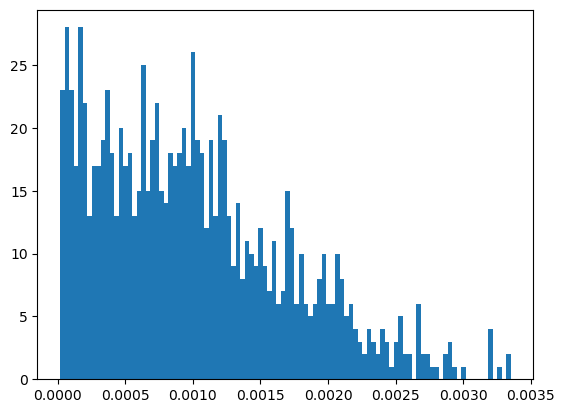

In [28]:
plt.hist(np.mean(A_x_samples,axis=0),bins=100)

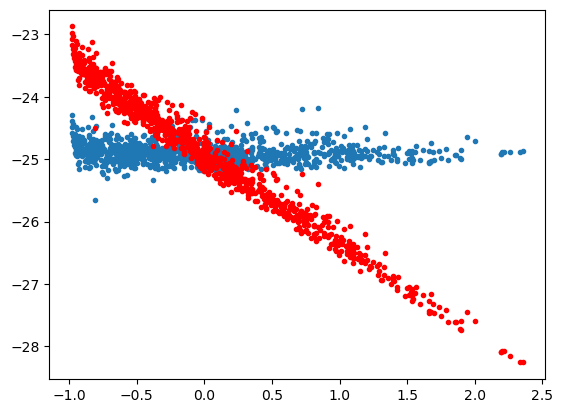

In [38]:
plt.plot(C.mean(axis=0),apr_mag_g[i_start:i_end]-d[i_start:i_end]+(C*a1_samples[:,None]).mean(axis=0),".")
plt.plot(C.mean(axis=0),apr_mag_g[i_start:i_end]-d[i_start:i_end],".",color='red')

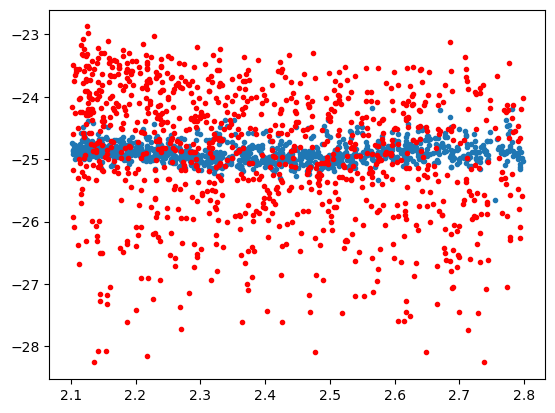

In [39]:
plt.plot(z[i_start:i_end],apr_mag_g[i_start:i_end]-d[i_start:i_end]+(C*a1_samples[:,None]).mean(axis=0),".")
plt.plot(z[i_start:i_end],apr_mag_g[i_start:i_end]-d[i_start:i_end],".",color='red')

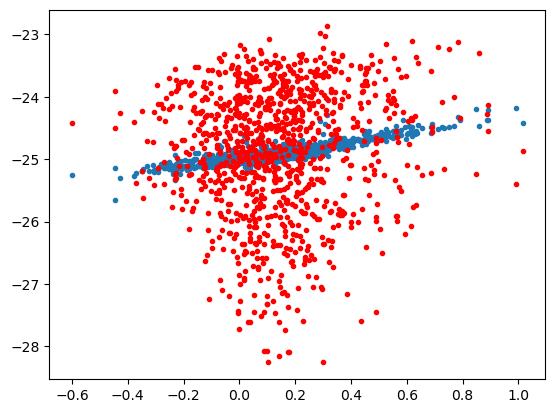

In [40]:
plt.plot((apr_mag_g-apr_mag_r)[i_start:i_end],apr_mag_g[i_start:i_end]-d[i_start:i_end]+(C*a1_samples[:,None]).mean(axis=0),".")
plt.plot((apr_mag_g-apr_mag_r)[i_start:i_end],apr_mag_g[i_start:i_end]-d[i_start:i_end],".",color='red')

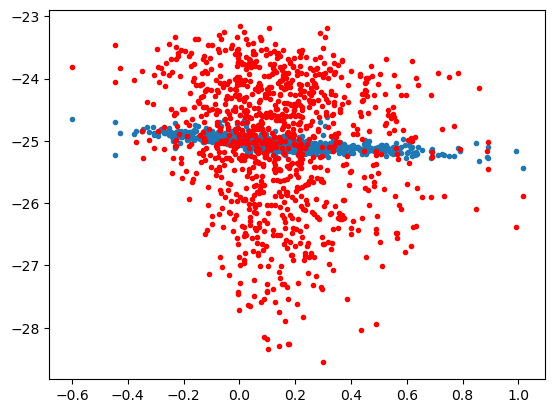

In [43]:
plt.plot((apr_mag_g-apr_mag_r)[i_start:i_end],apr_mag_r[i_start:i_end]-d[i_start:i_end]+(C*a2_samples[:,None]).mean(axis=0),".")
plt.plot((apr_mag_g-apr_mag_r)[i_start:i_end],apr_mag_r[i_start:i_end]-d[i_start:i_end],".",color='red')

(array([23., 28., 23., 17., 28., 22., 13., 17., 17., 19., 23., 18., 13.,
        20., 17., 18., 13., 15., 25., 15., 19., 22., 15., 14., 18., 17.,
        18., 20., 17., 25., 20., 18., 12., 19., 13., 21., 19., 13.,  9.,
        14.,  8., 11., 10.,  9., 12.,  9.,  7., 11.,  6.,  7., 15., 12.,
         6., 10.,  6.,  5.,  6.,  8., 10.,  6.,  6., 10.,  8.,  5.,  6.,
         4.,  3.,  2.,  4.,  3.,  2.,  4.,  3.,  1.,  3.,  5.,  2.,  2.,
         0.,  6.,  2.,  2.,  1.,  1.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  2.]),
 array([-1.429178  , -1.38066363, -1.33214915, -1.28363478, -1.2351203 ,
        -1.18660593, -1.13809144, -1.08957708, -1.04106259, -0.99254823,
        -0.9440338 , -0.89551938, -0.84700495, -0.79849052, -0.7499761 ,
        -0.70146167, -0.65294725, -0.60443282, -0.5559184 , -0.50740403,
        -0.45888957, -0.41037515, -0.36186075, -0.31334633, -0.2648319 ,
        -0.21631747, -0.16780305, -0.11928863, -0.07077421, -0.022259

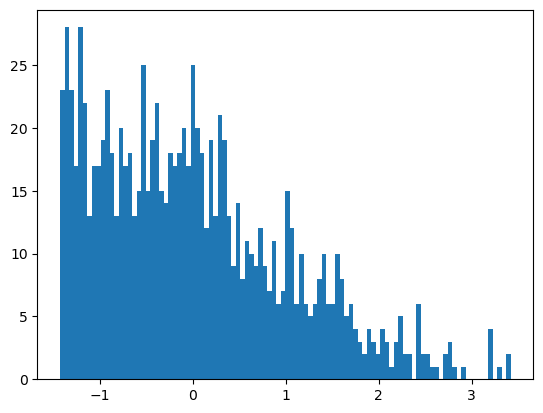

In [46]:
plt.hist((C*a2_samples[:,None]).mean(axis=0),bins=100)

(array([23., 27., 24., 17., 28., 22., 13., 17., 17., 19., 23., 18., 13.,
        20., 17., 18., 13., 15., 25., 15., 19., 22., 15., 14., 18., 17.,
        18., 20., 17., 26., 19., 18., 12., 19., 13., 21., 19., 13.,  9.,
        14.,  8., 11., 10.,  9., 12.,  9.,  7., 11.,  6.,  7., 15., 12.,
         6., 10.,  6.,  5.,  6.,  8., 10.,  6.,  6., 10.,  8.,  5.,  6.,
         4.,  3.,  2.,  4.,  3.,  2.,  4.,  3.,  1.,  3.,  5.,  2.,  2.,
         0.,  6.,  2.,  2.,  1.,  1.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  2.]),
 array([-1.41835129, -1.37020421, -1.32205725, -1.27391016, -1.22576308,
        -1.17761612, -1.12946904, -1.08132207, -1.03317499, -0.98502797,
        -0.93688089, -0.88873386, -0.84058684, -0.79243982, -0.74429274,
        -0.69614571, -0.64799869, -0.59985167, -0.55170459, -0.50355756,
        -0.45541054, -0.40726349, -0.35911646, -0.31096941, -0.26282239,
        -0.21467534, -0.1665283 , -0.11838126, -0.07023422, -0.022087

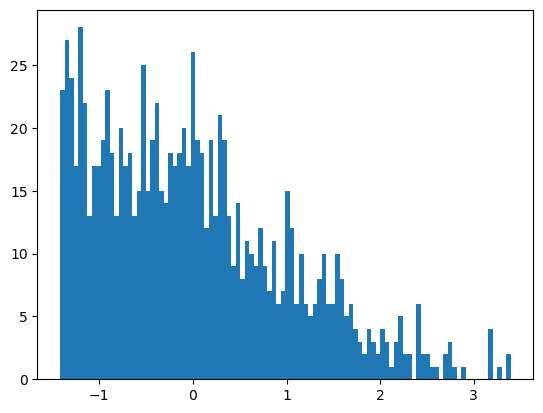

In [47]:
plt.hist((C*a1_samples[:,None]).mean(axis=0),bins=100)

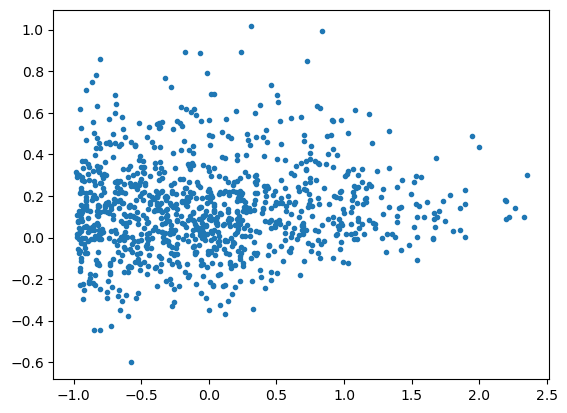

In [42]:
plt.plot(C.mean(axis=0),(apr_mag_g-apr_mag_r)[i_start:i_end],".")
#plt.plot((apr_mag_g-apr_mag_r)[i_start:i_end],apr_mag_g[i_start:i_end]-d[i_start:i_end],".",color='red')

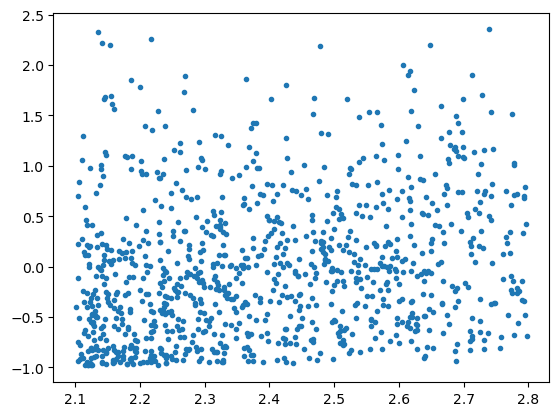

In [33]:
plt.plot(z[i_start:i_end],C.mean(axis=0),".")

In [14]:
C_x_final_step = (np.mean(A_x_samples,axis=0) - 1/(i_end-i_start))*(i_end-i_start)

In [15]:
C = A_x_samples*(i_end-i_start)-1

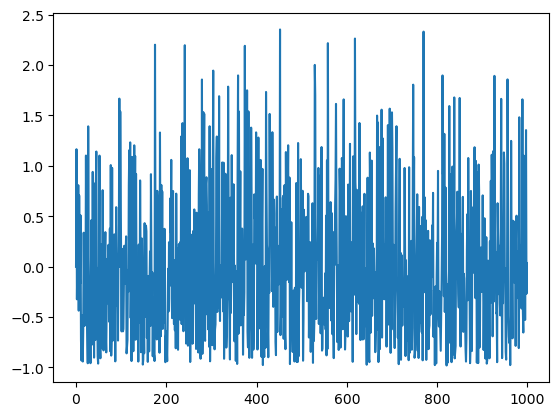

In [16]:
plt.plot(C.mean(axis=0),)

In [17]:
print(C.shape,a1_samples.shape)

(2000, 1000) (2000,)


In [18]:
x = C*a1_samples[:,None]

In [19]:
print(np.max(x),np.min(x))

3.771241 -1.5078088


In [20]:
x_mean = np.mean(x,axis=0)

In [21]:
print(x_mean.shape)

(1000,)


(array([23., 27., 24., 17., 28., 22., 13., 17., 17., 19., 23., 18., 13.,
        20., 17., 18., 13., 15., 25., 15., 19., 22., 15., 14., 18., 17.,
        18., 20., 17., 26., 19., 18., 12., 19., 13., 21., 19., 13.,  9.,
        14.,  8., 11., 10.,  9., 12.,  9.,  7., 11.,  6.,  7., 15., 12.,
         6., 10.,  6.,  5.,  6.,  8., 10.,  6.,  6., 10.,  8.,  5.,  6.,
         4.,  3.,  2.,  4.,  3.,  2.,  4.,  3.,  1.,  3.,  5.,  2.,  2.,
         0.,  6.,  2.,  2.,  1.,  1.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  2.]),
 array([-1.41835129, -1.37020421, -1.32205725, -1.27391016, -1.22576308,
        -1.17761612, -1.12946904, -1.08132207, -1.03317499, -0.98502797,
        -0.93688089, -0.88873386, -0.84058684, -0.79243982, -0.74429274,
        -0.69614571, -0.64799869, -0.59985167, -0.55170459, -0.50355756,
        -0.45541054, -0.40726349, -0.35911646, -0.31096941, -0.26282239,
        -0.21467534, -0.1665283 , -0.11838126, -0.07023422, -0.022087

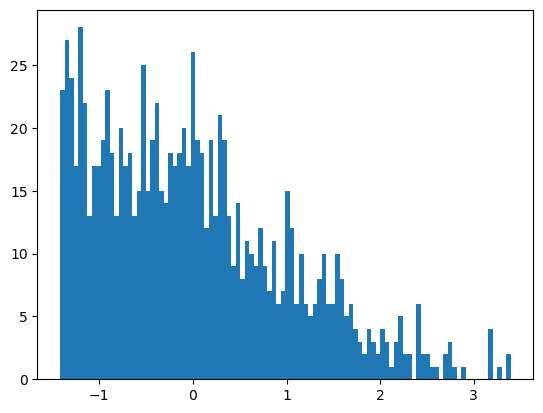

In [22]:
plt.hist(x_mean,bins=100)

(array([1., 3., 2., 1., 2., 2., 4., 3., 1., 4., 6., 4., 3., 3., 3., 2., 2.,
        3., 0., 2., 2., 5., 4., 1., 1., 2., 0., 4., 3., 1., 2., 1., 2., 0.,
        2., 0., 2., 3., 2., 3., 3., 2., 3., 2., 2., 0., 4., 3., 5., 4., 2.,
        4., 3., 5., 0., 2., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 3.,
        0., 1., 2., 0., 2., 2., 2., 1., 4., 3., 0., 1., 1., 1., 2., 3., 0.,
        2., 4., 2., 1., 1., 3., 0., 3., 2., 2., 2., 1., 2., 3., 1., 2., 4.,
        1., 2., 2., 2., 1., 5., 2., 2., 1., 1., 1., 0., 0., 1., 5., 2., 4.,
        3., 0., 1., 3., 3., 0., 1., 1., 0., 2., 2., 4., 1., 3., 0., 3., 2.,
        1., 0., 5., 1., 4., 3., 1., 1., 3., 0., 0., 3., 1., 1., 3., 2., 1.,
        1., 2., 0., 2., 3., 2., 2., 4., 1., 1., 2., 1., 0., 1., 0., 1., 2.,
        0., 1., 1., 2., 3., 2., 0., 2., 3., 1., 4., 1., 1., 4., 2., 2., 2.,
        5., 2., 2., 2., 4., 1., 1., 1., 0., 1., 3., 2., 0., 5., 3., 3., 0.,
        0., 1., 3., 1., 1., 2., 3., 4., 3., 1., 3., 1., 2., 2., 1., 2., 0.,
        2., 

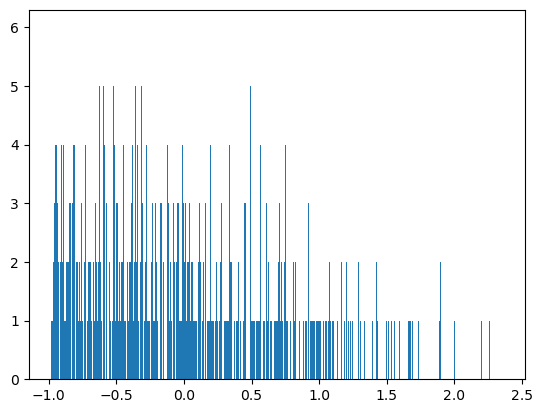

In [23]:
plt.hist(C_x_final_step,bins=1000)

In [24]:
a1_final_step = a1_samples[-1]
a2_final_step = a2_samples[-1]

(array([1., 3., 2., 1., 2., 2., 4., 3., 1., 4., 6., 4., 3., 3., 3., 2., 2.,
        3., 0., 2., 2., 5., 4., 1., 1., 2., 0., 4., 3., 1., 2., 1., 2., 0.,
        2., 0., 2., 3., 2., 3., 3., 2., 3., 2., 2., 0., 4., 3., 5., 4., 2.,
        4., 3., 5., 0., 2., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 3.,
        0., 1., 2., 0., 2., 2., 2., 1., 4., 3., 0., 1., 1., 1., 2., 3., 0.,
        2., 4., 2., 1., 1., 3., 0., 3., 2., 2., 2., 1., 2., 3., 1., 2., 4.,
        1., 2., 2., 2., 1., 5., 2., 2., 1., 1., 1., 0., 0., 1., 5., 2., 4.,
        3., 0., 1., 3., 3., 0., 1., 1., 0., 2., 2., 4., 1., 3., 0., 3., 2.,
        1., 0., 5., 1., 4., 3., 1., 1., 3., 0., 0., 3., 1., 1., 3., 2., 1.,
        1., 2., 0., 2., 3., 2., 2., 4., 1., 1., 2., 1., 0., 1., 0., 1., 2.,
        0., 1., 1., 2., 3., 2., 0., 2., 3., 1., 4., 1., 1., 4., 2., 2., 2.,
        5., 2., 2., 2., 4., 1., 1., 1., 0., 1., 3., 2., 0., 5., 3., 3., 0.,
        0., 1., 3., 1., 1., 2., 3., 4., 3., 1., 3., 1., 2., 2., 1., 2., 0.,
        2., 

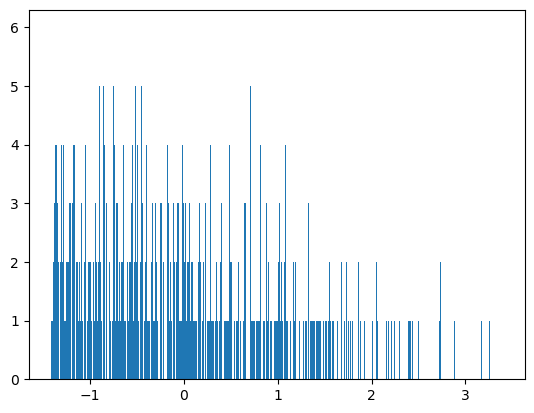

In [25]:
plt.hist(a1_final_step*C_x_final_step,bins=1000)

(array([1., 3., 2., 1., 2., 2., 4., 3., 1., 4., 6., 4., 3., 3., 3., 2., 2.,
        3., 0., 2., 2., 5., 4., 1., 1., 2., 0., 4., 3., 1., 2., 1., 2., 0.,
        2., 0., 2., 3., 2., 3., 3., 2., 3., 2., 2., 0., 4., 3., 5., 4., 2.,
        4., 3., 5., 0., 2., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 3.,
        0., 1., 2., 0., 2., 2., 2., 1., 4., 3., 0., 1., 1., 1., 2., 3., 0.,
        2., 4., 2., 1., 1., 3., 0., 3., 2., 2., 2., 1., 2., 3., 1., 2., 4.,
        1., 2., 2., 2., 1., 5., 2., 2., 1., 1., 1., 0., 0., 1., 5., 2., 4.,
        3., 0., 1., 3., 3., 0., 1., 1., 0., 2., 2., 4., 1., 3., 0., 3., 2.,
        1., 0., 5., 1., 4., 3., 1., 1., 3., 0., 0., 3., 1., 1., 3., 2., 1.,
        1., 2., 0., 2., 3., 2., 2., 4., 1., 1., 2., 1., 0., 1., 0., 1., 2.,
        0., 1., 1., 2., 3., 2., 0., 2., 3., 1., 4., 1., 1., 4., 2., 2., 2.,
        5., 2., 2., 2., 4., 1., 1., 1., 0., 1., 3., 2., 0., 5., 3., 3., 0.,
        0., 1., 3., 1., 1., 2., 3., 4., 3., 1., 3., 1., 2., 2., 1., 2., 0.,
        2., 

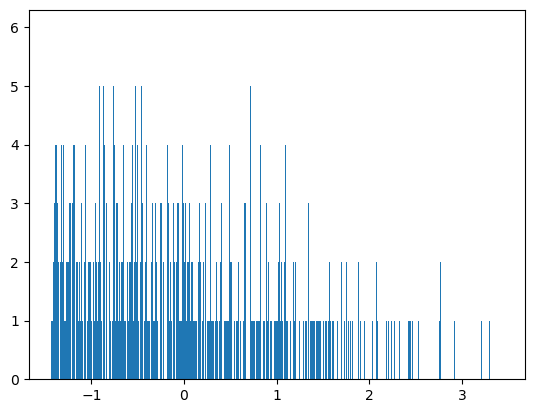

In [26]:
plt.hist(a2_final_step*C_x_final_step,bins=1000)

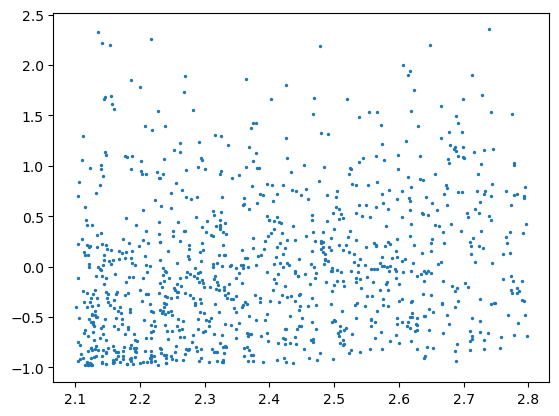

In [27]:
plt.scatter(z[i_start:i_end],C_x_final_step,s=2)